In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Load CIFAR-10
(x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32")

# Normalize to [-1,1]
x_train = (x_train / 127.5) - 1.0

IMG_SIZE = 32
BATCH_SIZE = 64
NOISE_DIM = 128
EPOCHS = 30

In [ ]:
dataset = (tf.data.Dataset.from_tensor_slices(x_train)
           .shuffle(50000)
           .batch(BATCH_SIZE, drop_remainder=True)
           .prefetch(tf.data.AUTOTUNE))

CELL 3 — Susnata Generator (DCGAN)

In [ ]:
def susnata_generator(noise_dim=NOISE_DIM):
    g = tf.keras.Sequential(name="susnata_cifar_generator")

    g.add(layers.Input(shape=(noise_dim,)))
    g.add(layers.Dense(4*4*512, use_bias=False))
    g.add(layers.BatchNormalization())
    g.add(layers.ReLU())
    g.add(layers.Reshape((4, 4, 512)))

    g.add(layers.Conv2DTranspose(256, 4, strides=2, padding='same', use_bias=False))
    g.add(layers.BatchNormalization()); g.add(layers.ReLU())

    g.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False))
    g.add(layers.BatchNormalization()); g.add(layers.ReLU())

    g.add(layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False))
    g.add(layers.BatchNormalization()); g.add(layers.ReLU())

    # Output size: 32x32x3
    g.add(layers.Conv2DTranspose(3, 3, strides=1, padding='same', activation='tanh'))
    return g

generator = susnata_generator()
generator.summary()

Model: "susnata_cifar_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8192)           │     1,048,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8192)           │        32,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 3)      │         1,731 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,837,379 (14.64 MB)

 Trainable params: 3,820,099 (14.57 MB)

 Non-trainable params: 17,280 (67.50 KB)

CELL 4 — Susnata Discriminator

In [ ]:
def susnata_discriminator():
    d = tf.keras.Sequential(name="susnata_cifar_discriminator")

    d.add(layers.Input(shape=(32, 32, 3)))

    d.add(layers.Conv2D(64, 4, strides=2, padding='same'))
    d.add(layers.LeakyReLU(0.2))

    d.add(layers.Conv2D(128, 4, strides=2, padding='same'))
    d.add(layers.LeakyReLU(0.2))

    d.add(layers.Conv2D(256, 4, strides=2, padding='same'))
    d.add(layers.LeakyReLU(0.2))

    d.add(layers.Flatten())
    d.add(layers.Dense(1))
    return d

discriminator = susnata_discriminator()
discriminator.summary()

Model: "susnata_cifar_discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 662,977 (2.53 MB)

 Trainable params: 662,977 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

gen_opt = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

@tf.function
def train_step(real_imgs):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # Train D
    with tf.GradientTape() as d_tape:
        fake_imgs = generator(noise, training=True)
        real_out = discriminator(real_imgs, training=True)
        fake_out = discriminator(fake_imgs, training=True)

        real_labels = tf.random.uniform([BATCH_SIZE, 1], 0.8, 1.0)
        fake_labels = tf.zeros([BATCH_SIZE, 1])

        d_loss = cross_entropy(real_labels, real_out) + cross_entropy(fake_labels, fake_out)

    grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    disc_opt.apply_gradients(zip(grads, discriminator.trainable_variables))

    # Train G
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    with tf.GradientTape() as g_tape:
        fake_imgs = generator(noise, training=True)
        fake_out = discriminator(fake_imgs, training=True)
        g_loss = cross_entropy(tf.ones_like(fake_out), fake_out)

    grads = g_tape.gradient(g_loss, generator.trainable_variables)
    gen_opt.apply_gradients(zip(grads, generator.trainable_variables))

    return d_loss, g_loss

Epoch 1/30 — D: 1.3381 | G: 0.9737


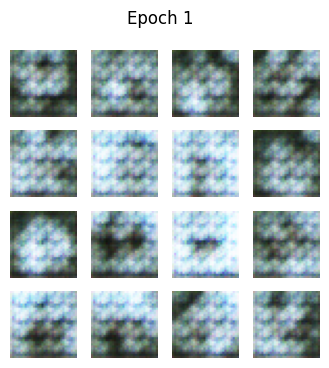

Epoch 2/30 — D: 1.1143 | G: 1.2728


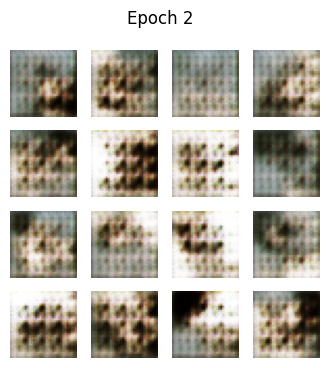

Epoch 3/30 — D: 1.4639 | G: 1.6218


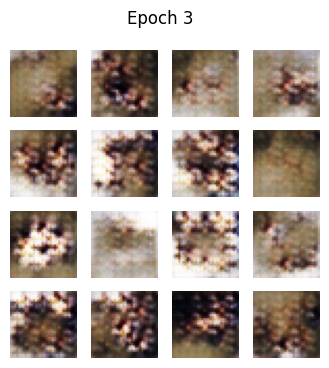

Epoch 4/30 — D: 1.3529 | G: 1.4156


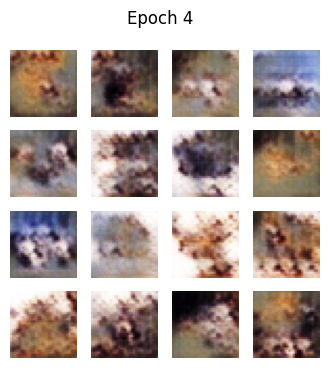

Epoch 5/30 — D: 1.3480 | G: 1.1790


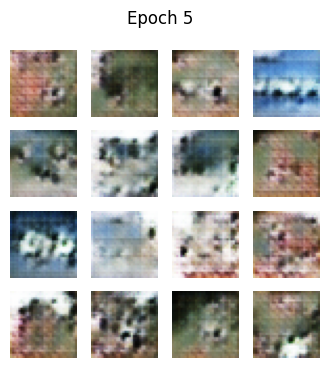

Epoch 6/30 — D: 1.1917 | G: 1.2262


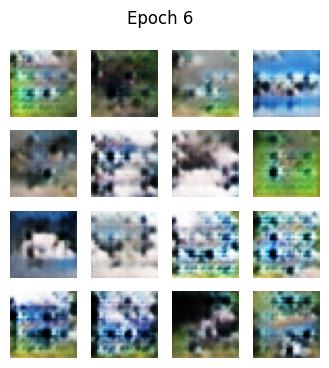

Epoch 7/30 — D: 1.1581 | G: 1.1052


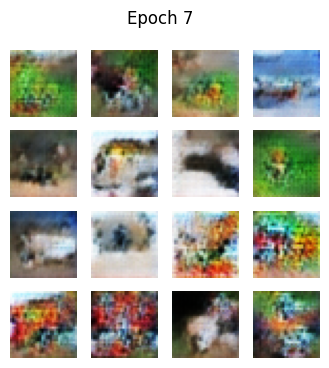

Epoch 8/30 — D: 1.2401 | G: 1.0426


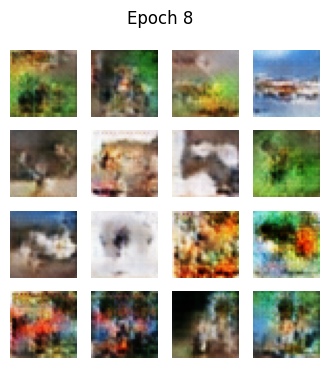

Epoch 9/30 — D: 1.3086 | G: 0.8474


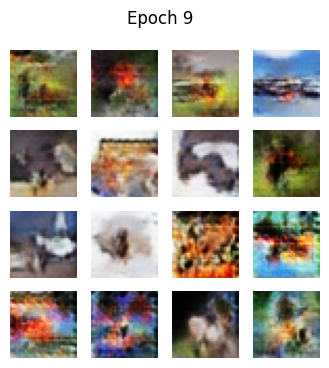

Epoch 10/30 — D: 1.3533 | G: 0.9984


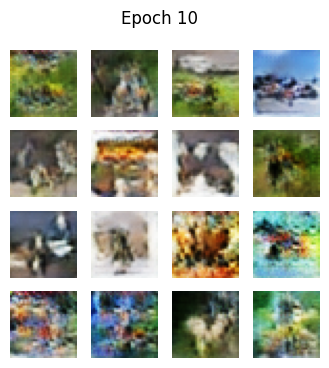

Epoch 11/30 — D: 1.3054 | G: 0.9143


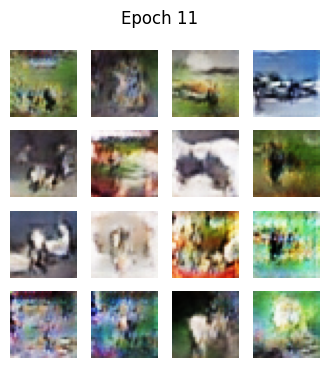

Epoch 12/30 — D: 1.3382 | G: 0.9414


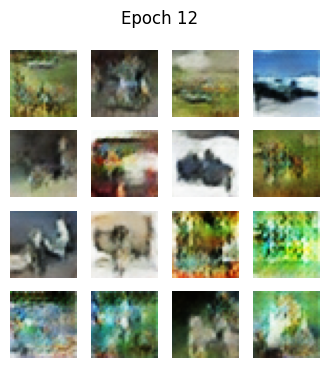

Epoch 13/30 — D: 1.3954 | G: 0.7892


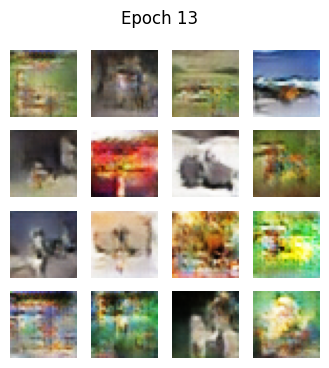

Epoch 14/30 — D: 1.3611 | G: 0.8884


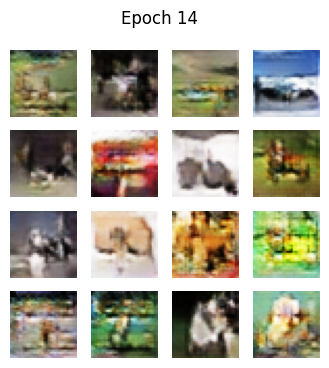

Epoch 15/30 — D: 1.3269 | G: 0.9191


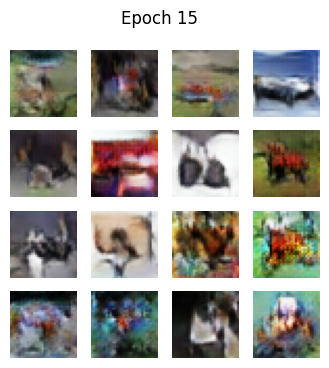

Epoch 16/30 — D: 1.1927 | G: 0.9690


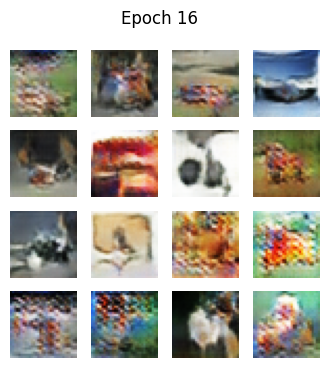

Epoch 17/30 — D: 1.3315 | G: 0.8861


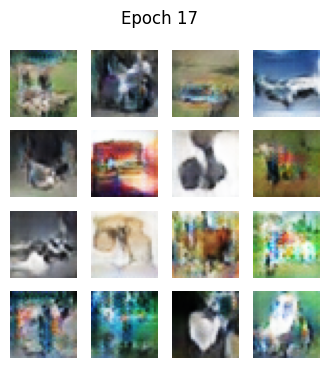

Epoch 18/30 — D: 1.3155 | G: 0.9466


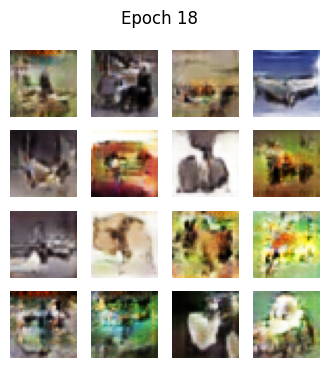

Epoch 19/30 — D: 1.3029 | G: 0.9249


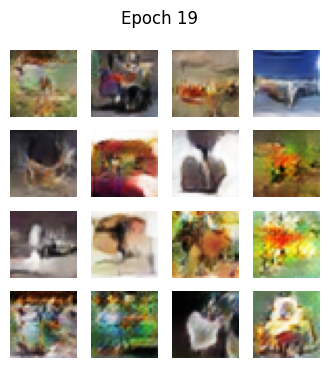

Epoch 20/30 — D: 1.2609 | G: 0.9500


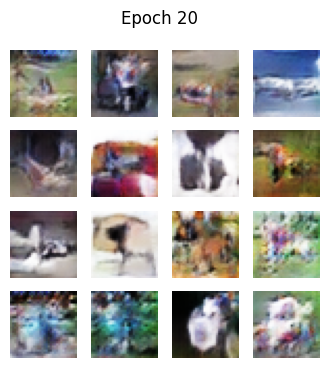

Epoch 21/30 — D: 1.3000 | G: 0.8859


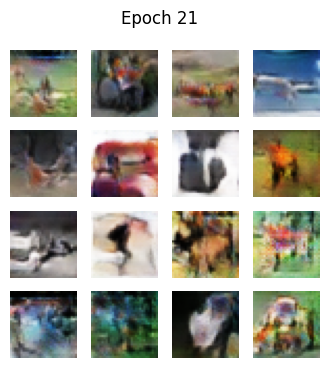

Epoch 22/30 — D: 1.3439 | G: 0.9086


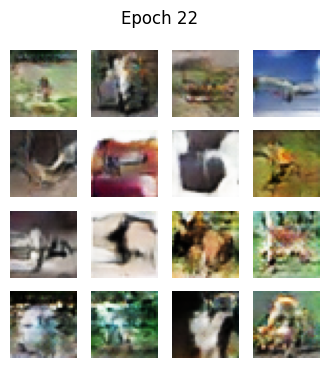

Epoch 23/30 — D: 1.2925 | G: 0.9189


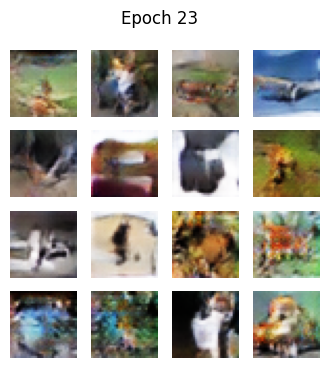

Epoch 24/30 — D: 1.2950 | G: 0.8924


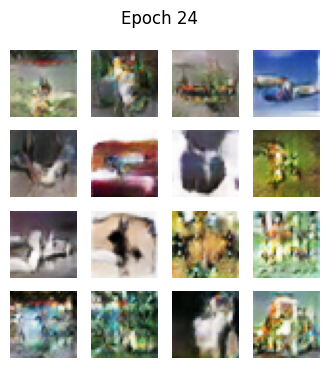

Epoch 25/30 — D: 1.2575 | G: 1.0936


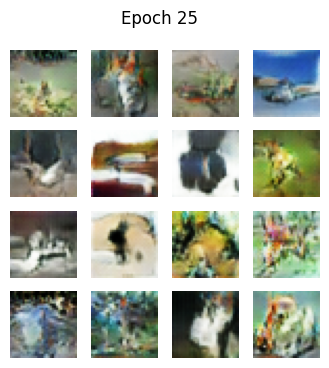

Epoch 26/30 — D: 1.3754 | G: 0.9734


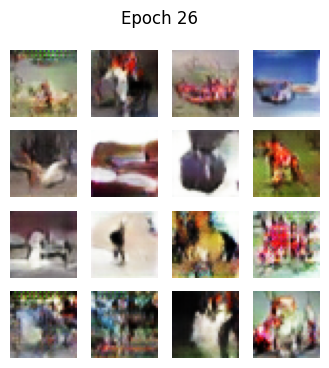

Epoch 27/30 — D: 1.2431 | G: 0.9244


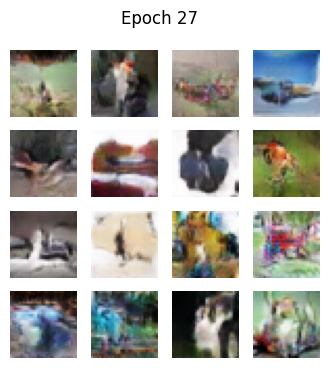

Epoch 28/30 — D: 1.3264 | G: 0.8895


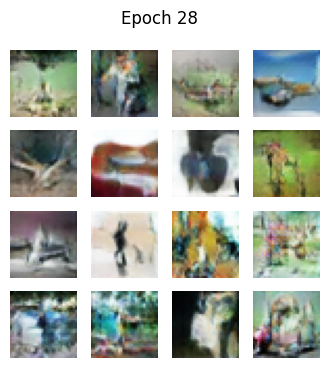

Epoch 29/30 — D: 1.2613 | G: 0.9408


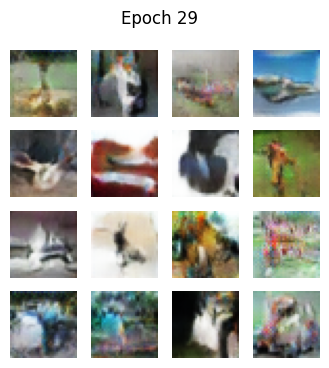

Epoch 30/30 — D: 1.2774 | G: 0.9589


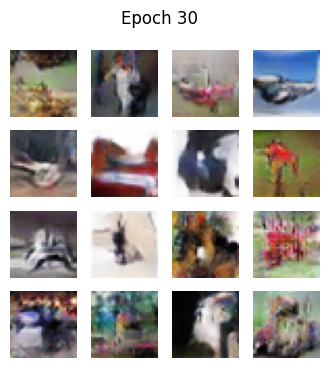

In [ ]:
fixed_noise = tf.random.normal([16, NOISE_DIM])

def show_samples(epoch):
    imgs = generator(fixed_noise, training=False)
    imgs = (imgs + 1) / 2.0

    plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(imgs[i])
        plt.axis("off")
    plt.suptitle(f"Epoch {epoch}")
    plt.show()

for epoch in range(1, EPOCHS+1):
    for batch in dataset:
        d_loss, g_loss = train_step(batch)

    print(f"Epoch {epoch}/{EPOCHS} — D: {d_loss:.4f} | G: {g_loss:.4f}")
    show_samples(epoch)

Final Losses

Discriminator Loss (D): 1.27

Generator Loss (G): 0.95

My take will be honest :

This model is still not upto the mark The reason being


A healthy GAN usually keeps both losses in a moderate range, while constantly challenging each other.

But here

Discriminator loss is high → the discriminator is not learning well

Generator loss is low → the generator is fooling the discriminator too easily

So even though the generated images look colorful and somewhat meaningful, the model is mostly learning textures and rough patterns, not real CIFAR shapes.
This happens when the generator becomes stronger too early, and the discriminator fails to give useful feedback.

This is not the correct equilibrium for a GAN, and it explains why the output is still abstract instead of showing clear objects.

Why this happened:

Training was only 30 epochs

CIFAR-10 is harder than MNIST

Basic DCGAN is unstable on this dataset

Discriminator needs more stabilization tricks

Fixes for future training:

Train 100–200 epochs

Use label smoothing

Add noise to discriminator inputs

Consider WGAN or different tyoes of other GANS like Style GAN but they are resource intensive

In short
The GAN is running, but the generator–discriminator balance is not right yet, and that affects image quality.

In [ ]:
The generator loss is lower than the discriminator loss, which means the generator is fooling the discriminator too easily.
This usually happens when the discriminator becomes weak during training.
Because of this, the generator learns mostly colors and textures, not complete object shapes.

So the generated images look abstract but meaningful, not fully realistic.
This is normal for a basic DCGAN trained on CIFAR-10 for only 30 epochs.

This result is not wrong, but it also shows that the model needs:

more epochs (100–200)

In [ ]:
generator.save("/content/susnata_cifar_dcgan.h5")
print("Saved as susnata_cifar_dcgan.h5")